In [1]:
import gym

import tensorflow as tf
from tensorflow import keras
print(tf.test.gpu_device_name())

import cv2

import numpy as np
from collections import deque

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

from pyglet.window import key
import time

In [2]:
actions = np.array([0.0, 0.0, 0.0]) 

In [3]:
env_name = "CarRacing-v0"
env = gym.make(env_name)

env.seed(42)
np.random.seed(42)

C:\Users\antol\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
class ObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def observation(self, inputs):
        inputs = cv2.cvtColor(inputs, cv2.COLOR_BGR2GRAY)
        inputs = inputs.astype(float)
        inputs /= 255.0
        inputs = np.expand_dims(inputs, axis=-1)
        return inputs

In [5]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def render_policy_net(env, model, action_space, seed=42):
        frames = []
        env.seed(seed)
        np.random.seed(seed)
        obs = env.reset()
        negative_reward_counter=0
        for step in range(1000):
            frames.append(env.render(mode="rgb_array"))
            action_probas = model(obs[np.newaxis])
            print('action_probas', action_probas)
            p=tf.squeeze(action_probas).numpy()
            p /= np.sum(p)
            action = np.random.choice(range(5), p=p)
            print('action', action)
            obs, reward, done, info = env.step(action_space[action])
            if reward < 0:
                negative_reward_counter +=1
            else :
                negative_reward_counter = 0
            if done or negative_reward_counter > 75 :
                break
        env.close()
        return frames

## Human Playing

In [6]:
bool_do_not_quit = True
scores = []

# arg 0 : steering angle (-1 to 1)
# arg 1 : velocity (0 to 1)
# arg 2 : braking (0 to 1)

def press_key(k, mod):
    global bool_do_not_quit, actions, restart
    if k==0xff0d: restart = True
    if k==key.ESCAPE: bool_do_not_quit=False
    if k==key.Q: bool_do_not_quit=False
    if k==key.LEFT:  actions[0] = -1.0
    if k==key.RIGHT: actions[0] = +1.0
    if k==key.UP:    actions[1] = +1.0
    if k==key.DOWN:  actions[2] = +0.8

def release_key(k, mod):
    global actions
    if k==key.LEFT  and actions[0]==-1.0: actions[0] = 0
    if k==key.RIGHT and actions[0]==+1.0: actions[0] = 0
    if k==key.UP:    actions[1] = 0
    if k==key.DOWN:  actions[2] = 0

def run_carRacing_asHuman(policy=None, record_video=False):
    global bool_do_not_quit, actions, restart
    # env = CarRacing()
    env = gym.make('CarRacing-v0').env

    env.reset()
    env.render()
    if record_video:
        env.monitor.start('/tmp/video-test', force=True)
    env.viewer.window.on_key_press = press_key
    env.viewer.window.on_key_release = release_key

    while bool_do_not_quit:
        env.reset()
        total_reward = 0.0
        steps = 0
        restart = False
        t1 = time.time()  # Trial timer
        while bool_do_not_quit:
            state, reward, done, info = env.step(actions)
            # time.sleep(1/10)  # Slow down to 10fps for us poor little human!
            total_reward += reward
            if steps % 200 == 0 or done:
                print("Step: {} | Reward: {:+0.2f}".format(steps, total_reward), "| Action:", actions)
            steps += 1
            if not record_video: # Faster, but you can as well call env.render() every time to play full window.
                env.render()
            if done or restart:
                t1 = time.time()-t1
                scores.append(total_reward)
                print("Trial", len(scores), "| Score:", total_reward, '|', steps, "steps | %0.2fs."% t1)
                break
        if not bool_do_not_quit:
            scores.append(total_reward)
            print("Trial", len(scores), "| Score:", total_reward, '|', steps, "steps | %0.2fs."% t1)
    env.close()

run_carRacing_asHuman()  # Run with human keyboard input

Track generation: 1077..1359 -> 282-tiles track
Track generation: 1328..1664 -> 336-tiles track
Step: 0 | Reward: +5.87 | Action: [0. 0. 0.]
Step: 200 | Reward: -2.19 | Action: [0. 1. 0.]
Step: 400 | Reward: +67.36 | Action: [0. 0. 0.]
Step: 600 | Reward: +148.86 | Action: [0. 0. 0.]
Trial 1 | Score: 238.51791044776314 | 779 steps | 23.24s.
Track generation: 918..1158 -> 240-tiles track
Step: 0 | Reward: +8.27 | Action: [0. 0. 0.]
Step: 200 | Reward: +143.08 | Action: [-1.  0.  0.]
Step: 400 | Reward: +277.89 | Action: [0. 0. 0.]
Step: 600 | Reward: +421.07 | Action: [0. 0. 0.]
Step: 800 | Reward: +555.88 | Action: [0. 0. 0.]
Trial 2 | Score: 574.3037656903667 | 826 steps | 23.13s.
Track generation: 1109..1398 -> 289-tiles track
Step: 0 | Reward: +6.84 | Action: [0. 0. 0.]
Step: 200 | Reward: +156.98 | Action: [0. 0. 0.]
Step: 400 | Reward: +279.34 | Action: [-1.  0.  0.]
Step: 600 | Reward: +446.84 | Action: [0. 0. 0.]
Step: 800 | Reward: +576.15 | Action: [1. 0. 0.]
Step: 1000 | Rewa

In [9]:
env.close()

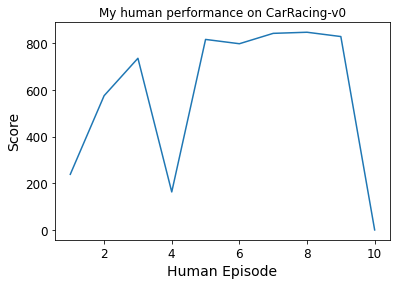

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title('My human performance on CarRacing-v0')
plt.ylabel('Score')
plt.xlabel('Human Episode')
plt.show()